In [19]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

In [2]:
df = pd.read_csv('AmesHousing.tsv',delimiter='\t')
def transform_features(df):
    return df
def select_features(df):
    return df[['Gr Liv Area','SalePrice']]
def train_and_test(df):
    train = df[1460:]
    test = df[:1460]
    features = df.select_dtypes(['int', 'float']).columns.drop('SalePrice')
    model = linear_model.LinearRegression()
    model.fit(train[features], train['SalePrice'])
    predictions = model.predict(test[features])
    rmse = mean_squared_error(predictions, test['SalePrice'])**.5
    return rmse
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)
rmse

56197.260867074234

# Feature Engineering
- Which columns contain less than 5% missing values?
- What new features can we create, that better capture the information in some of the features?
- Which columns need to be dropped for other reasons?

## Columns contain less than 5% 

- For numerical columns that meet this criteria, let's fill in the missing values using the most popular value for that column.

In [3]:
# drop cols with more than 5% missing value
mv_pct = df.isna().sum()/df.shape[0]
mv_cols = mv_pct[mv_pct>.05].index
df = df.drop(columns = mv_cols)

In [4]:
# replace mode for numeric columns
num_cols = df.select_dtypes(['int','float']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
df[num_cols].isna().sum()

Order              0
PID                0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
Mas Vnr Area       0
BsmtFin SF 1       0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
Mo Sold            0
Yr Sold            0
SalePrice          0
dtype: int64

In [5]:
# drop text columns with any missing value
text_cols = df.select_dtypes(['object']).columns
text_mv_cols = df[text_cols].isna().sum()[df[text_cols].isna().sum() > 0].index
df = df.drop(columns = text_mv_cols)
df.select_dtypes(include='object').isna().sum()

MS Zoning         0
Street            0
Lot Shape         0
Land Contour      0
Utilities         0
Lot Config        0
Land Slope        0
Neighborhood      0
Condition 1       0
Condition 2       0
Bldg Type         0
House Style       0
Roof Style        0
Roof Matl         0
Exterior 1st      0
Exterior 2nd      0
Exter Qual        0
Exter Cond        0
Foundation        0
Heating           0
Heating QC        0
Central Air       0
Kitchen Qual      0
Functional        0
Paved Drive       0
Sale Type         0
Sale Condition    0
dtype: int64

## New features
- Create new features:
    - `yr sold since built`, `yr sold since remod/add`
    - difference between built, remod/add and `Sold Year`

In [6]:
df[['Year Built','Year Remod/Add','Yr Sold']].head()

,Year Built,Year Remod/Add,Yr Sold
0,1960,1960,2010
1,1961,1961,2010
2,1958,1958,2010
3,1968,1968,2010
4,1997,1998,2010


In [7]:
df['yr sold since built'] = df['Yr Sold'] - df['Year Built'] 
df['yr sold since remod/add'] = df['Yr Sold'] - df['Year Remod/Add']
df = df.drop(index = df['yr sold since built'][df['yr sold since built'] < 0].index)
df = df.drop(index = df['yr sold since built'][df['yr sold since remod/add'] < 0].index)
df = df.drop(columns=['Year Built','Year Remod/Add'])
df.shape

(2927, 64)

## Drop columns
- Which columns aren't useful for machine learning?
- Which columns leak data about the final sale?

In [8]:
## Drop columns that aren't useful for ML
df = df.drop(columns = ["PID", "Order"])

## Drop columns that leak info about the final sale
df = df.drop(columns = ["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"])

# Generate a correlation heatmap matrix of the numerical features in the training data set

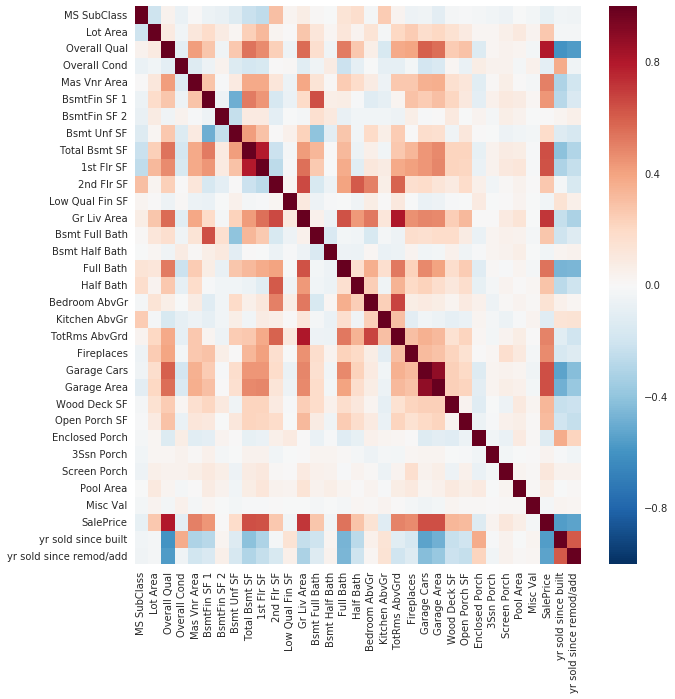

In [9]:
numeric_cols = df.select_dtypes(['int','float']).columns
corr_mat = df[numeric_cols].corr()
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(corr_mat, ax = ax)

## Calculate the correlation coefficients for the columns that seem to correlate well with `SalePrice`.
- high correlation = 0.4  

In [10]:
high_corr_cols = corr_mat[corr_mat['SalePrice'].abs().sort_values() >.4].index
high_corr_cols

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


Index(['Overall Qual', 'Mas Vnr Area', 'BsmtFin SF 1', 'Total Bsmt SF',
       '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Cars', 'Garage Area', 'SalePrice', 'yr sold since built',
       'yr sold since remod/add'],
      dtype='object')

## Which columns in the data frame should be converted to the categorical data type? 

In [11]:
df[high_corr_cols].info() # All high correlated columns are numerical. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 14 columns):
Overall Qual               2927 non-null int64
Mas Vnr Area               2927 non-null float64
BsmtFin SF 1               2927 non-null float64
Total Bsmt SF              2927 non-null float64
1st Flr SF                 2927 non-null int64
Gr Liv Area                2927 non-null int64
Full Bath                  2927 non-null int64
TotRms AbvGrd              2927 non-null int64
Fireplaces                 2927 non-null int64
Garage Cars                2927 non-null float64
Garage Area                2927 non-null float64
SalePrice                  2927 non-null int64
yr sold since built        2927 non-null int64
yr sold since remod/add    2927 non-null int64
dtypes: float64(5), int64(9)
memory usage: 343.0 KB


## Are there any ordinal variables?
- Which columns are currently numerical but need to be encoded as categorical instead (because the numbers don't have any semantic meaning)?
- How many unique value in `high_corr_cols`?
    - unique_value less than or equal 10 defines as catagorial var

In [12]:
unique_value_count = df[high_corr_cols].apply(lambda col: len(col.unique()))
cat_cols = unique_value_count[unique_value_count<=10].index
for col in cat_cols:
    df[col] = df[col].astype('category')
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 4 columns):
Overall Qual    2927 non-null category
Full Bath       2927 non-null category
Fireplaces      2927 non-null category
Garage Cars     2927 non-null category
dtypes: category(4)
memory usage: 35.3 KB


In [14]:
reg_df = pd.concat([df, pd.get_dummies(df[cat_cols])],axis = 'columns').drop(columns = cat_cols)
reg_df.shape

(2927, 80)

In [18]:
def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]

        lr.fit(train[features], train["SalePrice"])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test["SalePrice"], predictions)
        rmse = np.sqrt(mse)

        return rmse
    
    if k == 1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

rmse = train_and_test(reg_df, k=4)

rmse

[36320.00062039451, 24246.84965700123, 22569.269468466995, 23249.738500429354]


26596.46456157302

In [69]:
reg_df = reg_df.select_dtypes(['int','float'])
cross_val_score_rmse = abs(cross_val_score(linear_model.LinearRegression(), 
                X = reg_df.drop(columns = ['SalePrice']),
                y = reg_df['SalePrice'],
                scoring = 'neg_mean_squared_error',
                cv = KFold(n_splits = 4,
                           shuffle = True,
                           random_state = 1)
               ))**.5
print(cross_val_score_rmse)
cross_val_score_rmse.mean()

[43147.26305479 30675.70747481 29180.30587968 32989.34343685]


33998.15496153287